# Glacier module
## Juncal Norte - august, 2022
#### Paul Sandoval Quilodrán - https://github.com/SQPaul

## Import packages 

In [1]:
from landsat5 import landsat5
import rfclas 
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import glob
import subprocess
import matplotlib.pyplot as plt
from os import chdir, getcwd

## Download landsat5 images

In [5]:
mask = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\mask500gpkg.gpkg"
landsat5(mask,20,"2000-01-01","2000-05-31")

Lista de imágenes disponibles: 


,nubosidad,id,year,day,month
fecha,,,,,
2000-01-28 14:01:55.018050+00:00,1,LT05_232083_20000128,2000,28,1
2000-02-29 14:00:51.239006+00:00,3,LT05_232083_20000229,2000,29,2
2000-02-04 14:07:53.597056+00:00,0,LT05_233083_20000204,2000,4,2
2000-02-20 14:07:20.725038+00:00,1,LT05_233083_20000220,2000,20,2


¿Desea descargar las imágenes?: (escriba si o no) si


Descarga comenzada!! Pueden demorar unos minutos en aparacer las imágenes en Google Drive


## Calculate NDSI

In [2]:
#for Landsat5 1986-03-26

landsat_path = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Landsat\LT05_233083_20000204.tif"
landsat_new_path = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Landsat\NDSI_2000_02_04.tif"

l5 = rasterio.open(landsat_path)
B2 = l5.read(2)
B5 = l5.read(5)
NDSI_5 = (B2-B5)/(B2+B5)

# np.errstate(divide='ignore', invalid='ignore') Doesn't work 

#NDSI_5tif = rasterio.open(
#    landsat_new_path,
#    "w",
#    driver = "GTiff",
#    height = l5.shape[0],
#    width = l5.shape[1],
#    count = 1,
#    nodata = l5.nodata,
#    dtype = np.float64,
#    crs = 32719,
#    transform = l5.transform)
#NDSI_5tif.write(NDSI_5,1)
#NDSI_5tif.close()

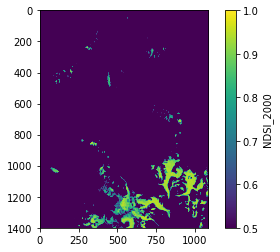

In [6]:
plt.imshow(NDSI_5,vmin=0.5,vmax=1)
plt.colorbar(label="NDSI_2000");

## Random forest clasification

C:\Users\pauls\Anaconda3\envs\gee\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Clases de uso de suelo:  ['no_glacier' 'glacier_free' 'glacier_debris']
Número de pixeles de muestra:  388811
La exactitud de nuestra predicción calculada usando out of bag score: 99.66847645771338
Peso de cada banda para discriminación de clases
Banda 1: 22.0759375311353
Banda 2: 19.292936048877014
Banda 3: 16.30204001101352
Banda 4: 13.250255567665475
Banda 5: 3.766434083004918
Banda 6: 20.770508846510545
Banda 7: 4.541887911793215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Area_km2,Uso
0,1214.7237,no_glacier
8,116.0037,glacier_free
17,36.0882,glacier_debris


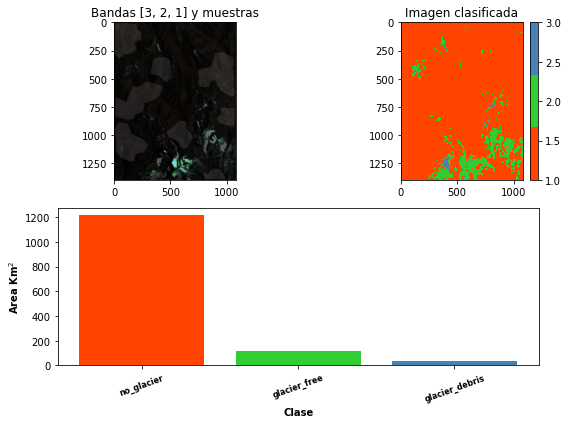

In [2]:
multiband = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Landsat\LT05_233083_20000204.tif"
poligonos = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\datos_entrenamiento.gpkg"
columna = "Uso"

rfclas.rfclas(multiband,poligonos,columna)

## Thickness ~2000 - Farinotti et al., 2019

In [9]:
rgi_basin_path = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\RGI_v6.0_JN_basin.shp"
glaciers = gpd.read_file(rgi_basin_path)

#Generate a list of glaciers id
glaciers_id = glaciers["RGIId"]

In [26]:
farinotti_folder = r"C:\Users\pauls\Desktop\Proyectos\PEGH_Aysen\Modulo_glaciar\input\thickness_farinotti\R"
farinotti_output = r"F:\Juncal_norte\FARINOTTI\R"

for i in glaciers_id:
    name = farinotti_folder+i[1:]+"_thickness.tif"
    new_name = farinotti_output+i[1:]+"_thickness32719.tif"
    layer = rasterio.open(name)
    layer_array = layer.read(1)
    
    #Zero values to nan
    for x in range(layer_array.shape[0]):
        for y in range(layer_array.shape[1]):
            if layer_array[x,y] == 0:
                layer_array[x,y] = np.nan
            
    new_layer = rasterio.open(str(new_name),
                             "w",
                             driver = "GTiff",
                             height = layer.shape[0],
                             width = layer.shape[1],
                             count = 1,
                             nodata = np.nan,
                             dtype = np.float64,
                             crs = 32719,
                             transform = layer.transform)
    new_layer.write(layer_array,1)
    new_layer.close()
    
#MERGE IN QGIS, IS BETTER

## Create csv 

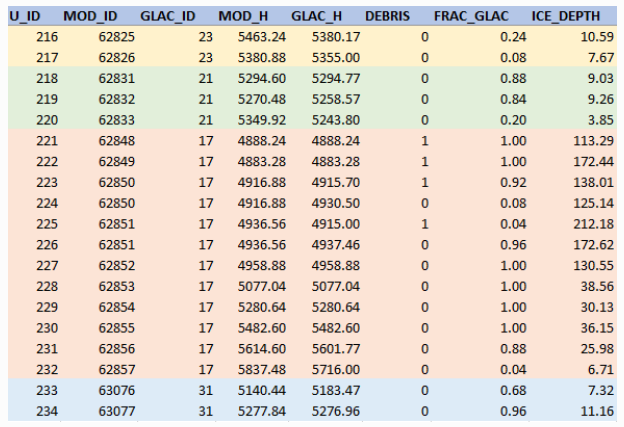

* U_ID = Unique combination per row.
* MOD_ID = One ID per cell in model domain.
* GLAC_ID = One ID per glacier (ice body).
* MOD_H = Elevation of model dem.
* GLAC_H = Elevation of glacier dem.
* DEB =  Flag indication if glacier cell has debris (True = 1) or is debris-free (False = 0).
* FRAC_GLAC = Fraction of the model cell that's covered with glacier cell. 
* ICE_DEPTH = Thickness of the glacier cell.

### Generate dem and thickness per glacier 
#### RUN IN QGIS

In [ ]:
#Cut by glacier mask layer!!!!!!!!!!!!!!!! LEFT

#Read thickness raster
thickness = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\thickness\*.tif")

#Read thickness raster
dem = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\dem\*.tif")

#gdalwarp. Define crs, resolution and extension
for i in range(len(thickness)):
    thick = thickness[i]
    thick_out = thickness[i][:-13]+"h.tif"
    elev = dem[i]
    elev_out = dem[i][:-7]+"elev.tif"
    processing.run("gdal:warpreproject", 
                   {'INPUT':str(thick),
                    'SOURCE_CRS':None,
                    'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'RESAMPLING':0,'NODATA':None,
                    'TARGET_RESOLUTION':100,
                    'OPTIONS':'',
                    'DATA_TYPE':0,
                    'TARGET_EXTENT':'380681.000000000,413181.000000000,6339419.000000000,6381419.000000000 [EPSG:32719]',
                    'TARGET_EXTENT_CRS':None,
                    'MULTITHREADING':False,
                    'EXTRA':'',
                    'OUTPUT':str(thick_out)})
    processing.run("gdal:warpreproject", 
                   {'INPUT':str(elev),
                    'SOURCE_CRS':None,
                    'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'RESAMPLING':0,'NODATA':None,
                    'TARGET_RESOLUTION':100,
                    'OPTIONS':'',
                    'DATA_TYPE':0,
                    'TARGET_EXTENT':'380681.000000000,413181.000000000,6339419.000000000,6381419.000000000 [EPSG:32719]',
                    'TARGET_EXTENT_CRS':None,
                    'MULTITHREADING':False,
                    'EXTRA':'',
                    'OUTPUT':str(elev_out)})

### Create model_id

In [ ]:
clone_tif = rasterio.open(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\juncalnorte_mask_v0.tif")
clone_array = clone_tif.read(1)

print(clone_tif.shape[0],clone_tif.shape[1])

for i in range(clone_tif.shape[0]):
    count = i*clone_tif.shape[1]
    for j in range(clone_tif.shape[1]):
        count2 = count+j+1
        clone_array[i,j] = count2
        
model_id = rasterio.open(
    r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\model_id.map","w",
    driver = "PCRaster",
    pcraster_valuescale = "VS_SCALAR",
    height = clone_tif.shape[0],
    width = clone_tif.shape[1],
    count = 1,
    nodata = np.nan,
    dtype = np.float32,
    crs = 32719,
    transform = clone_tif.transform)
model_id.write(clone_array,1)
model_id.close()

### Create model_id - model_dem in glacier shape
#### RUN IN QGIS

In [25]:
glaciers = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\per_glacier\*.shp")


for i in range(len(glaciers)):
    name_id = glaciers[i][:-21]+"model_id"+glaciers[i][81:-4]+"_model_id.tif"
    final_name_id = glaciers[i][:-21]+"model_id"+glaciers[i][81:-4]+"_modelID.tif"
    name_dem = glaciers[i][:-21]+"dem_model"+glaciers[i][81:-4]+"_model_dem.tif"
    final_name_dem = glaciers[i][:-21]+"dem_model"+glaciers[i][81:-4]+"_modelDEM.tif"
    
    #MODEL ID
    #Cut by glacier mask layer
    processing.run("gdal:cliprasterbymasklayer",
                   {'INPUT':'C:/Users/pauls/Desktop/Proyectos/Juncal_norte/GIS/model_id.map',
                    'MASK':str(glaciers[i]),
                    'SOURCE_CRS':None,'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'NODATA':None,'ALPHA_BAND':False,'CROP_TO_CUTLINE':True,'KEEP_RESOLUTION':False,
                    'SET_RESOLUTION':False,'X_RESOLUTION':100,'Y_RESOLUTION':100,'MULTITHREADING':False,
                    'OPTIONS':'','DATA_TYPE':0,'EXTRA':'',
                    'OUTPUT':str(name_id)})
    #Define crs, resolution and extention
    processing.run("gdal:warpreproject",
                   {'INPUT':str(name_id),
                    'SOURCE_CRS':None,'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'RESAMPLING':0,'NODATA':None,'TARGET_RESOLUTION':100,
                    'OPTIONS':'','DATA_TYPE':0,
                    'TARGET_EXTENT':'380681.000000000,413181.000000000,6339419.000000000,6381419.000000000 [EPSG:32719]',
                    'TARGET_EXTENT_CRS':None,'MULTITHREADING':False,'EXTRA':'',
                    'OUTPUT':(final_name_id)})
    
    #MODEL DEM
    #Cut by glacier mask layer
    processing.run("gdal:cliprasterbymasklayer",
                   {'INPUT':'C:/Users/pauls/Desktop/Proyectos/Juncal_norte/GIS/dem500.tif',
                    'MASK':str(glaciers[i]),
                    'SOURCE_CRS':None,'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'NODATA':None,'ALPHA_BAND':False,'CROP_TO_CUTLINE':True,'KEEP_RESOLUTION':False,
                    'SET_RESOLUTION':False,'X_RESOLUTION':100,'Y_RESOLUTION':100,'MULTITHREADING':False,
                    'OPTIONS':'','DATA_TYPE':0,'EXTRA':'',
                    'OUTPUT':str(name_dem)})
    #Define crs, resolution and extention
    processing.run("gdal:warpreproject",
                   {'INPUT':str(name_dem),
                    'SOURCE_CRS':None,'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                    'RESAMPLING':0,'NODATA':None,'TARGET_RESOLUTION':100,
                    'OPTIONS':'','DATA_TYPE':0,
                    'TARGET_EXTENT':'380681.000000000,413181.000000000,6339419.000000000,6381419.000000000 [EPSG:32719]',
                    'TARGET_EXTENT_CRS':None,'MULTITHREADING':False,'EXTRA':'',
                    'OUTPUT':(final_name_dem)})

### Create csv per glacier

* RGI60-17.14053.
* RGI60-17.14088. 
* RGI60-17.14092.
* RGI60-17.14093.

In [4]:
thickness = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\thickness\*.tif")
elevation = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\dem_glacier\*.tif")
model_id = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\model_id\*.tif")
dem_model = glob.glob(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\dem_model\*.tif")
detritus = rasterio.open(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\detritus\detritus.tif").read(1)

mod_id = []
glac_id = []
mod_h = []
glac_h = []
deb = []
frac_glac = []
ice_depth = [] 

for i in range(len(thickness)):
    
    #Thickness
    thick_ras = rasterio.open(str(thickness[i]))
    thick_array = thick_ras.read(1)
    
    #Glacier elevation
    elev_ras = rasterio.open(str(elevation[i]))
    elev_array = elev_ras.read(1)
    
    #Model_id
    id_ras = rasterio.open(str(model_id[i]))
    id_array = id_ras.read(1)
    
    #DEM model
    dem_ras = rasterio.open(str(dem_model[i]))
    dem_array = dem_ras.read(1)
    
    for x in range(thick_ras.shape[0]):
        for y in range(thick_ras.shape[1]):
            if thick_array[x,y] != 0 and thick_array[x,y] != np.nan:
                mod_id.append(id_array[x,y])
                glac_id.append(int(thickness[i][80:-6]))
                mod_h.append("{:.2f}".format(dem_array[x,y]))
                glac_h.append("{:.2f}".format(elev_array[x,y]))
                ice_depth.append("{:.2f}".format(thick_array[x,y]))
                frac_glac.append(1/25)
                if detritus[x,y] == 1:
                    deb.append(1)
                else:
                    deb.append(0)
                
                               
u_id = list(range(1,len(mod_id)+1))
glacier_csv = pd.DataFrame(np.column_stack([u_id, mod_id, glac_id, mod_h, glac_h, deb, frac_glac, ice_depth]), 
                               columns=["U_ID","MOD_ID", "GLAC_ID", "MOD_H", "GLAC_H", "DEBRIS", "FRAC_GLAC", "ICE_DEPTH"])
glacier_csv.to_csv(r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data\glaciers_csv.csv",index=False)

In [3]:
glacier_csv

,U_ID,MOD_ID,GLAC_ID,MOD_H,GLAC_H,DEBRIS,FRAC_GLAC,ICE_DEPTH
0,1,4653.0,14053,4940.86,5019.95,0,0.04,23.62
1,2,4653.0,14053,4940.86,5004.73,1,0.04,30.13
2,3,4653.0,14053,4940.86,4935.57,0,0.04,29.72
3,4,4653.0,14053,4940.86,4868.57,0,0.04,33.44
4,5,4653.0,14053,4940.86,4826.14,0,0.04,44.40
...,...,...,...,...,...,...,...,...
1335,1336,4008.0,14093,4367.96,4384.67,0,0.04,27.36
1336,1337,4009.0,14093,4459.95,4392.40,1,0.04,29.08
1337,1338,4009.0,14093,4459.95,4414.98,0,0.04,24.22
1338,1339,4008.0,14093,4367.96,4362.44,0,0.04,20.01


#### Create glacier and model id nominal maps

In [ ]:
#Change directory

f_dir = r"C:\Users\pauls\Desktop\Proyectos\Juncal_norte\GIS\Glaciers\Input_data"
chdir(f_dir)

#Create function to convert from tif to map
def ConvertToPCRaster (src_fname,dst_fname,ot,VS):
    src_ds = gdal.Open(src_fname)
    dst_ds = gdal.Translate(dst_fname, src_ds, format="PCRaster", outputType=ot, metadataOptions=VS)
    src_ds = None
    dst_ds = None

ConvertToPCRaster("glacier_id_scalar.tif","glacier_id.map",gdalconst.GDT_Float32,"VS_SCALAR")
glacier_id_map = nominal("glacier_id.map")
report(glacier_id_map,"glacierID.map")

ConvertToPCRaster("model_id.tif","model_id.map",gdalconst.GDT_Float32,"VS_SCALAR")
model_id_map = nominal("model_id.map")
report(model_id_map,"modelID.map")